In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import librosa
from pathlib import Path

2025-01-25 20:24:42.035209: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-25 20:24:42.043601: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-25 20:24:42.055245: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-25 20:24:42.058346: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-25 20:24:42.066641: I tensorflow/core/platform/cpu_feature_guar

In [2]:
yamnet_model = hub.load("https://tfhub.dev/google/yamnet/1")


I0000 00:00:1737816883.978329  288535 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1737816884.020803  288535 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1737816884.024030  288535 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1737816884.028680  288535 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [3]:
def extract_embedding(file_path: Path) -> np.ndarray:
    """Extract YAMNet embeddings from audio file using pathlib Path"""
    audio, sr = librosa.load(str(file_path), sr=16000)

    if len(audio) < 16000:
        audio = np.pad(audio, (0, max(0, 16000 - len(audio))), mode="constant")
    else:
        audio = audio[:16000]

    audio = audio / np.max(np.abs(audio))

    _, embeddings, _ = yamnet_model(audio)

    return tf.reduce_mean(embeddings, axis=0).numpy()


In [4]:
data_dir = Path("Audio")
class_names = ["BACKGROUND", "DRONE", "HELICOPTER"]

file_paths = []
labels = []


In [5]:
for audio_file in data_dir.glob("*.wav"):
    class_name = str(audio_file).split("_")[0]
    file_paths.append(Path(audio_file))
    labels.append(class_name)


In [6]:
X = np.array([extract_embedding(fp) for fp in file_paths])


2025-01-25 20:24:46.967306: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90300
W0000 00:00:1737816887.030162  288641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737816887.043709  288641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737816887.044470  288641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737816887.050419  288641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737816887.051218  288641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737816887.052589  288641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737816887.053349  288641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737816887.054111  288641 gpu_

In [7]:
le = LabelEncoder()
y = le.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [8]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(1024,)),
        tf.keras.layers.Dense(2048, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1024, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(len(class_names), activation="softmax"),
    ]
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)


In [9]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=25, restore_best_weights=True
)

history = model.fit(
    X_train,
    y_train,
    epochs=250,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
)


model.save("audio_classifier.keras")


Epoch 1/250


I0000 00:00:1737816889.192663  288638 service.cc:146] XLA service 0x7f94540265b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737816889.192682  288638 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-01-25 20:24:49.209849: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4062 - loss: 1.1468

I0000 00:00:1737816890.670965  288638 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3961 - loss: 1.1379

2025-01-25 20:24:53.723089: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_44', 356 bytes spill stores, 404 bytes spill loads

2025-01-25 20:24:53.814141: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_44', 4 bytes spill stores, 4 bytes spill loads



2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 4s/step - accuracy: 0.3927 - loss: 1.1350 - val_accuracy: 0.3333 - val_loss: 1.0998
Epoch 2/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.4720 - loss: 1.0261 - val_accuracy: 0.3333 - val_loss: 1.0774
Epoch 3/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.4161 - loss: 1.0535 - val_accuracy: 0.4000 - val_loss: 1.0544
Epoch 4/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5046 - loss: 0.9915 - val_accuracy: 0.4667 - val_loss: 1.0325
Epoch 5/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5409 - loss: 0.9985 - val_accuracy: 0.6667 - val_loss: 1.0100
Epoch 6/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.4850 - loss: 1.0009 - val_accuracy: 0.7333 - val_loss: 0.9859
Epoch 7/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5864 - loss: 0.9340 - val_accuracy: 0.7333 - val_loss: 0.9605
Epoch 8/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6047 - loss: 0.9296 - val_accuracy: 0.7333 - val_loss: 0.9346
Epoch 

In [10]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_acc:.5%}")


2025-01-25 20:25:13.676823: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_44', 32 bytes spill stores, 32 bytes spill loads

2025-01-25 20:25:13.778412: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_37', 40 bytes spill stores, 56 bytes spill loads

2025-01-25 20:25:13.812906: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_37', 204 bytes spill stores, 204 bytes spill loads

2025-01-25 20:25:14.258188: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_44', 12 bytes spill stores, 12 bytes spill loads

2025-01-25 20:25:14.273804: I external/local_xla/xla/stream_execut

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8333 - loss: 1.0844

Test Accuracy: 83.33333%


In [11]:
# loaded_model = tf.keras.models.load_model("audio_classifier.keras")

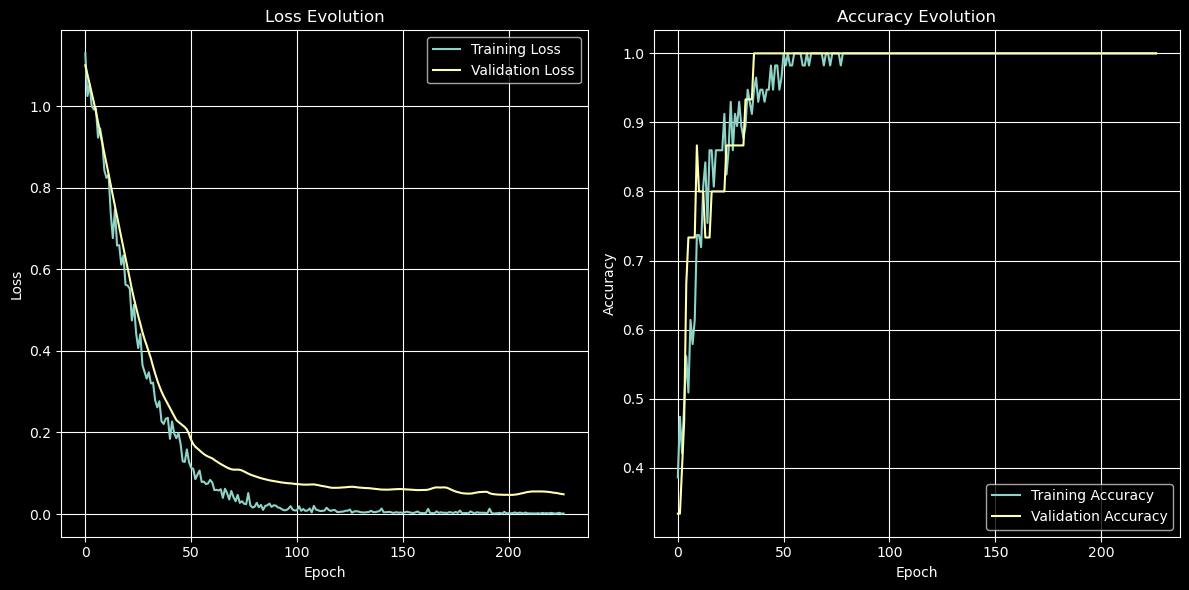


Final Evaluation:
Test Loss: 1.0844
Test Accuracy: 83.33%


In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss Evolution")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy Evolution")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("\nFinal Evaluation:")
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2%}")
